In [13]:
# common_data.py
# Loads & preprocesses the breast cancer dataset (NO PCA)

import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

def load_and_preprocess(test_size=0.2):
    data = load_breast_cancer()
    X = data.data
    y = data.target

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=RANDOM_SEED
    )

    return X_train, X_test, y_train, y_test


In [14]:
# extra_plots.py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    precision_recall_curve,
    roc_curve
)
from sklearn.calibration import calibration_curve


# ---------------- Accuracy Curve ----------------
def plot_accuracy_curve(acc_list, title="Accuracy Curve", fname=None):
    plt.figure(figsize=(6,4))
    plt.plot(acc_list, marker='o')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    if fname: plt.savefig(fname)
    plt.show()


# ---------------- F1 Curve ----------------
def plot_f1_curve(f1_list, title="F1 Score Curve", fname=None):
    plt.figure(figsize=(6,4))
    plt.plot(f1_list, marker='o', color="green")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.grid(True)
    if fname: plt.savefig(fname)
    plt.show()


# ---------------- Precision Recall ----------------
def plot_precision_recall(y_true, y_prob, title="Precision-Recall Curve", fname=None):
    p, r, _ = precision_recall_curve(y_true, y_prob)
    plt.figure(figsize=(6,5))
    plt.plot(r, p)
    plt.title(title)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    if fname: plt.savefig(fname)
    plt.show()


# ---------------- Probability Histogram ----------------
def plot_probability_hist(y_prob, title="Probability Distribution", fname=None):
    plt.figure(figsize=(6,4))
    sns.histplot(y_prob, bins=20, kde=True)
    plt.title(title)
    plt.xlabel("Predicted Probability")
    plt.ylabel("Count")
    if fname: plt.savefig(fname)
    plt.show()


# ---------------- Calibration Curve ----------------
def plot_calibration_curve(y_true, y_prob, title="Calibration Curve", fname=None):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
    plt.figure(figsize=(6,5))
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0,1],[0,1],'--')
    plt.title(title)
    plt.xlabel("Predicted Probability")
    plt.ylabel("True Probability")
    plt.grid(True)
    if fname: plt.savefig(fname)
    plt.show()


# ---------------- Normalized Confusion Matrix ----------------
def plot_confusion_matrix_simple(cm, labels=["Malignant", "Benign"], title="Confusion Matrix", fname=None):
    """
    Simple 2x2 confusion matrix with raw counts (NO normalization)
    """

    cm = np.array(cm)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm,
                annot=True,
                fmt="d",          # integer format
                cmap="Blues",
                xticklabels=labels,
                yticklabels=labels)

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)

    if fname:
        plt.savefig(fname, dpi=200, bbox_inches='tight')

    plt.show()


[Classical] Epoch 1/100 | train_loss: 0.6312 | val_loss: 0.5416 | val_acc: 0.9386
[Classical] Epoch 10/100 | train_loss: 0.0515 | val_loss: 0.0802 | val_acc: 0.9737
[Classical] Epoch 20/100 | train_loss: 0.0256 | val_loss: 0.0844 | val_acc: 0.9649
[Classical] Epoch 30/100 | train_loss: 0.0148 | val_loss: 0.0937 | val_acc: 0.9649
[Classical] Epoch 40/100 | train_loss: 0.0084 | val_loss: 0.0910 | val_acc: 0.9737
[Classical] Epoch 50/100 | train_loss: 0.0029 | val_loss: 0.1110 | val_acc: 0.9649
[Classical] Epoch 60/100 | train_loss: 0.0018 | val_loss: 0.1231 | val_acc: 0.9649
[Classical] Epoch 70/100 | train_loss: 0.0011 | val_loss: 0.1288 | val_acc: 0.9649
[Classical] Epoch 80/100 | train_loss: 0.0007 | val_loss: 0.1358 | val_acc: 0.9649
[Classical] Epoch 90/100 | train_loss: 0.0005 | val_loss: 0.1409 | val_acc: 0.9649
[Classical] Epoch 100/100 | train_loss: 0.0004 | val_loss: 0.1479 | val_acc: 0.9649
[Classical] Training completed in 1.9s

[Classical] Test metrics:
  Accuracy : 0.9649
 

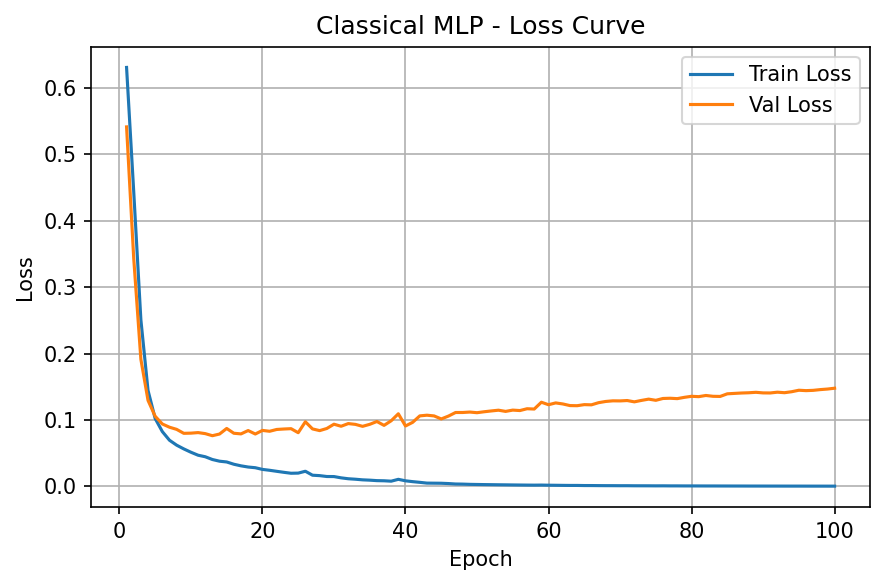

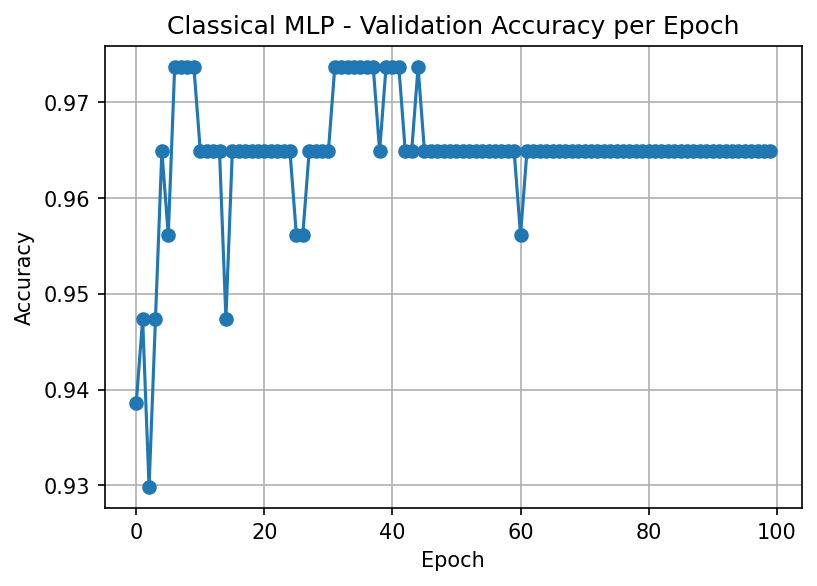

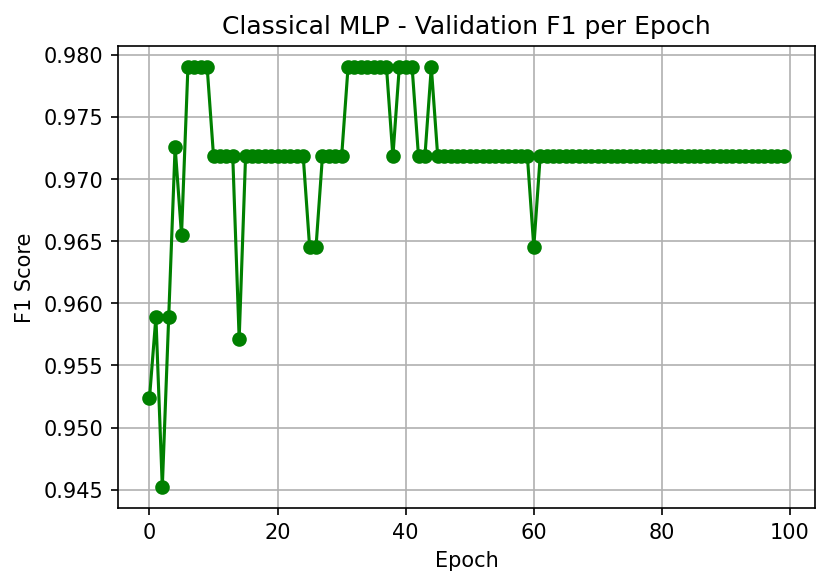

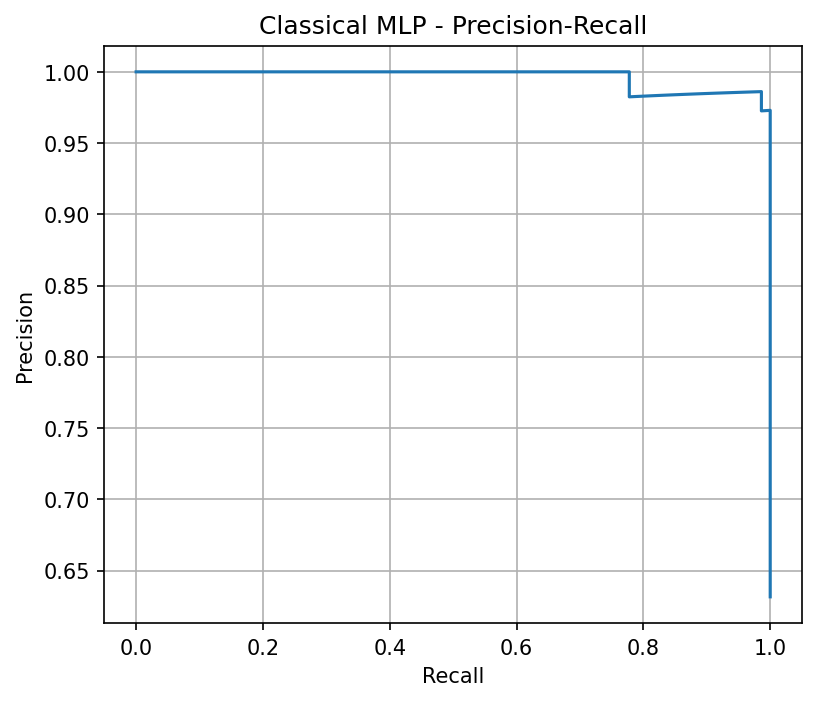

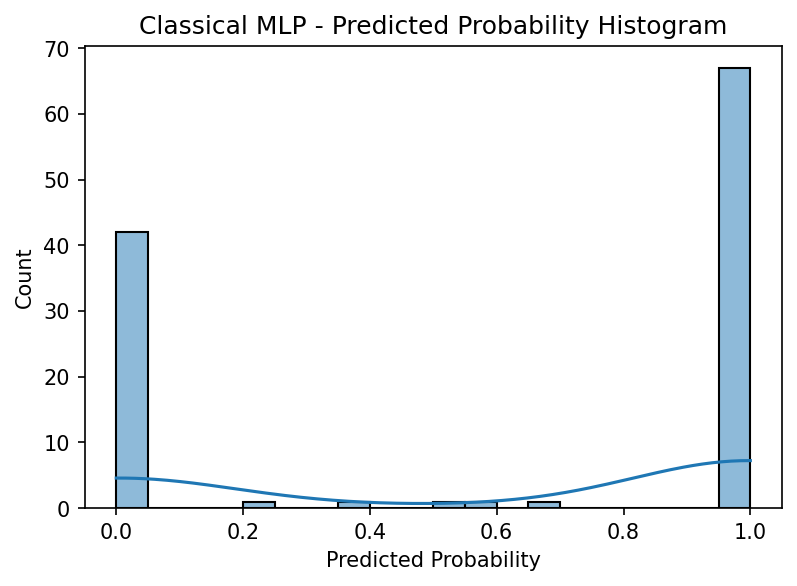

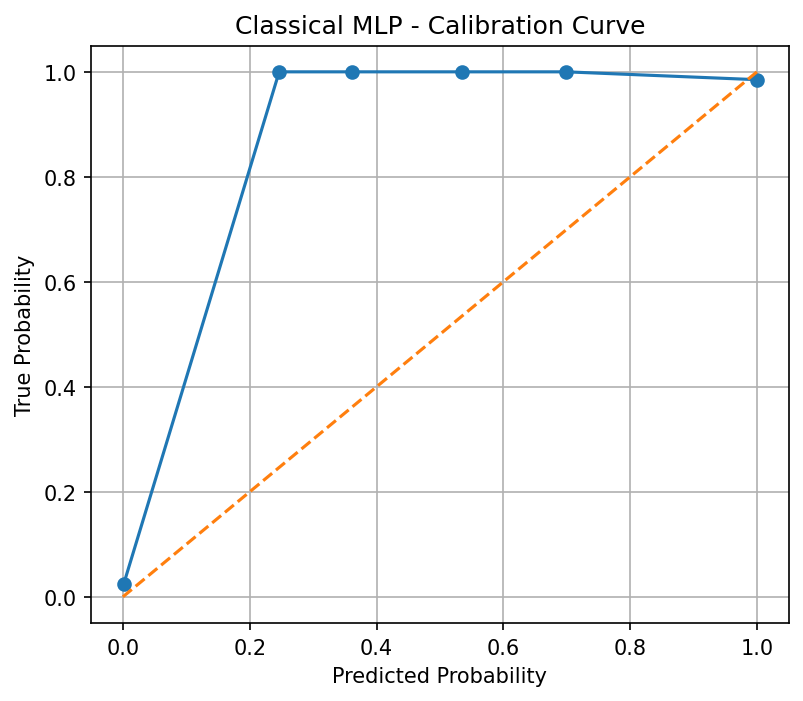

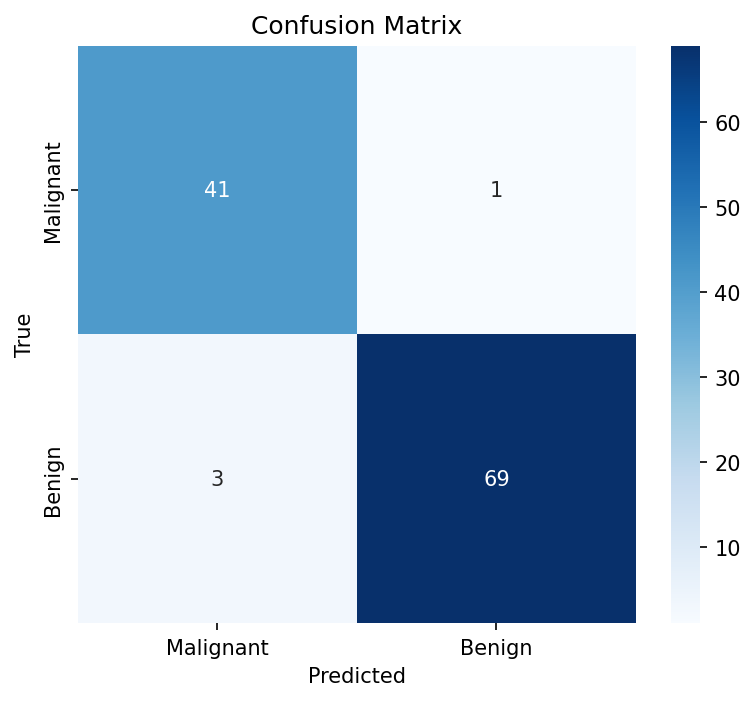

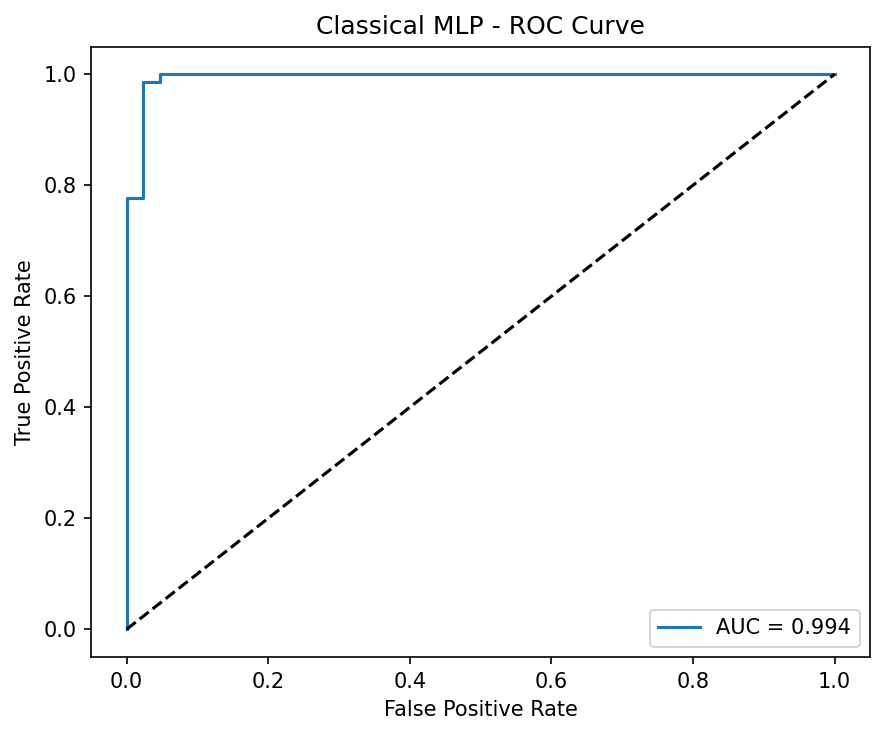

In [15]:
# train_classical.py

import matplotlib.pyplot as plt

# High-resolution figures
plt.rcParams["figure.dpi"] = 150

# Always show plots inline for Jupyter/VSCode
try:
    get_ipython()
    %matplotlib inline
except:
    pass

# Interactive mode ON for Python scripts
plt.ion()

import os
import time
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

# ---------------- Config ----------------
RANDOM_SEED = 42
os.makedirs("figures_classical", exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- Reproducibility ----------------
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# ---------------- Data ----------------
X_train, X_test, y_train, y_test = load_and_preprocess(test_size=0.2)

# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)

# ---------------- Model ----------------
class ClassicalMLP(nn.Module):
    def __init__(self, input_dim=30, h1=64, h2=32, n_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.ReLU(),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Linear(h2, n_classes)
        )
    def forward(self, x):
        return self.net(x)

model = ClassicalMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ---------------- Training params ----------------
epochs = 100
batch_size = 32
n_samples = X_train_t.shape[0]

# For tracking
train_losses = []
val_losses = []
acc_list = []
f1_list = []
val_acc_list = []
val_f1_list = []

start_time = time.time()
for epoch in range(1, epochs + 1):
    model.train()
    perm = torch.randperm(n_samples)
    running_loss = 0.0

    for i in range(0, n_samples, batch_size):
        idx = perm[i:i+batch_size]
        xb = X_train_t[idx]
        yb = y_train_t[idx]

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)

    epoch_loss = running_loss / n_samples
    train_losses.append(epoch_loss)

    # End-of-epoch evaluation on train and validation
    model.eval()
    with torch.no_grad():
        # Train metrics
        logits_train = model(X_train_t)
        probs_train = torch.softmax(logits_train, dim=1)[:,1].cpu().numpy()
        preds_train = torch.argmax(logits_train, dim=1).cpu().numpy()
        train_acc = accuracy_score(y_train, preds_train)
        train_f1 = f1_score(y_train, preds_train)
        acc_list.append(train_acc)
        f1_list.append(train_f1)

        # Validation/test metrics
        logits_val = model(X_test_t)
        probs_val = torch.softmax(logits_val, dim=1)[:,1].cpu().numpy()
        preds_val = torch.argmax(logits_val, dim=1).cpu().numpy()
        val_acc = accuracy_score(y_test, preds_val)
        val_f1 = f1_score(y_test, preds_val)
        val_acc_list.append(val_acc)
        val_f1_list.append(val_f1)

        # Validation loss (for tracking)
        val_loss = criterion(logits_val, y_test_t).item()
        val_losses.append(val_loss)

    if epoch % 10 == 0 or epoch == 1:
        print(f"[Classical] Epoch {epoch}/{epochs} | train_loss: {epoch_loss:.4f} | val_loss: {val_loss:.4f} | val_acc: {val_acc:.4f}")

total_time = time.time() - start_time
print(f"[Classical] Training completed in {total_time:.1f}s")

# ---------------- Final Evaluation ----------------
model.eval()
with torch.no_grad():
    logits_test = model(X_test_t)
    probs_test = torch.softmax(logits_test, dim=1)[:,1].cpu().numpy()
    preds_test = torch.argmax(logits_test, dim=1).cpu().numpy()

acc = accuracy_score(y_test, preds_test)
f1 = f1_score(y_test, preds_test)
try:
    roc = roc_auc_score(y_test, probs_test)
except Exception:
    roc = None
cm = confusion_matrix(y_test, preds_test)

print("\n[Classical] Test metrics:")
print(f"  Accuracy : {acc:.4f}")
print(f"  F1-score : {f1:.4f}")
print(f"  ROC-AUC  : {roc if roc is not None else 'NA'}")
print(f"  Confusion matrix:\n{cm}")
# ---------------- Save & Plot Figures ----------------

# LOSS CURVE
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Classical MLP - Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("figures_classical/classical_loss_curve.png", dpi=200)
plt.show()

# ACCURACY & F1 CURVES
plot_accuracy_curve(val_acc_list, title="Classical MLP - Validation Accuracy per Epoch",
                    fname="figures_classical/classical_val_accuracy.png")
plt.show()

plot_f1_curve(val_f1_list, title="Classical MLP - Validation F1 per Epoch",
              fname="figures_classical/classical_val_f1.png")
plt.show()

# PRECISION-RECALL
plot_precision_recall(y_test, probs_test, title="Classical MLP - Precision-Recall",
                      fname="figures_classical/classical_pr_curve.png")
plt.show()

# PROBABILITY HISTOGRAM
plot_probability_hist(probs_test, title="Classical MLP - Predicted Probability Histogram",
                      fname="figures_classical/classical_prob_hist.png")
plt.show()

# CALIBRATION CURVE
plot_calibration_curve(y_test, probs_test, title="Classical MLP - Calibration Curve",
                       fname="figures_classical/classical_calibration.png")
plt.show()

# NORMALIZED CONFUSION MATRIX
plot_confusion_matrix_simple(cm, labels=["Malignant", "Benign"],
                          fname="figures_classical/classical_confusion_norm.png")
plt.show()

# ROC
if roc is not None:
    fpr, tpr, _ = roc_curve(y_test, probs_test)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc:.3f}")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Classical MLP - ROC Curve")
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig("figures_classical/classical_roc_curve.png", dpi=200)
    plt.show()



In [16]:
classical_acc = acc
classical_f1 = f1
classical_auc = roc


[VQC] Epoch 1/30 loss_train=0.4065 loss_val=0.3994 val_acc=0.8421 time=6.24s
[VQC] Epoch 2/30 loss_train=0.3898 loss_val=0.4016 val_acc=0.8596 time=6.64s
[VQC] Epoch 3/30 loss_train=0.3882 loss_val=0.4049 val_acc=0.8596 time=5.75s
[VQC] Epoch 4/30 loss_train=0.3894 loss_val=0.4191 val_acc=0.8596 time=5.27s
[VQC] Epoch 5/30 loss_train=0.3879 loss_val=0.4119 val_acc=0.8684 time=5.77s
[VQC] Epoch 6/30 loss_train=0.3881 loss_val=0.4053 val_acc=0.8596 time=5.85s
[VQC] Epoch 7/30 loss_train=0.3959 loss_val=0.4356 val_acc=0.8421 time=5.59s
[VQC] Epoch 8/30 loss_train=0.3916 loss_val=0.4255 val_acc=0.8509 time=5.79s
[VQC] Epoch 9/30 loss_train=0.3882 loss_val=0.4138 val_acc=0.8684 time=5.74s
[VQC] Epoch 10/30 loss_train=0.3879 loss_val=0.4123 val_acc=0.8684 time=5.39s
[VQC] Epoch 11/30 loss_train=0.3878 loss_val=0.4110 val_acc=0.8684 time=5.78s
[VQC] Epoch 12/30 loss_train=0.3878 loss_val=0.4078 val_acc=0.8596 time=5.38s
[VQC] Epoch 13/30 loss_train=0.3881 loss_val=0.4052 val_acc=0.8596 time=5

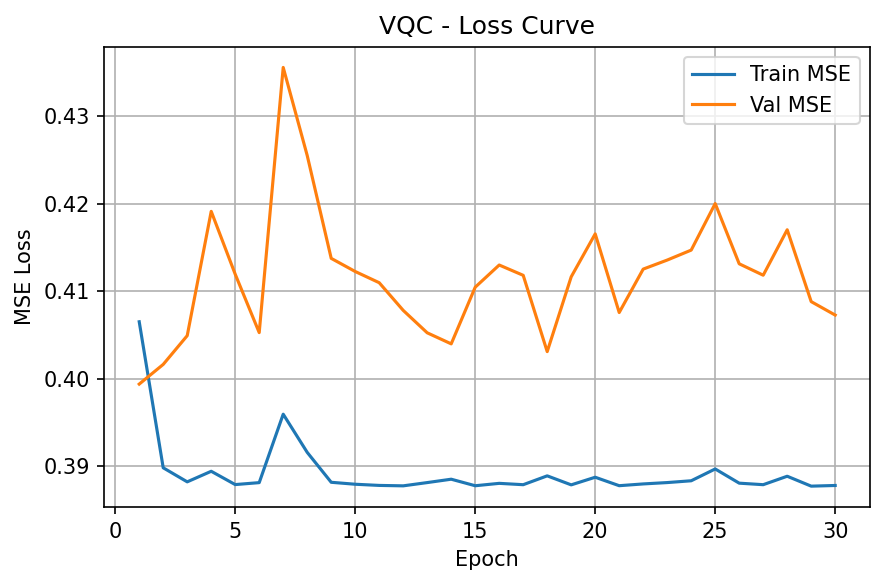

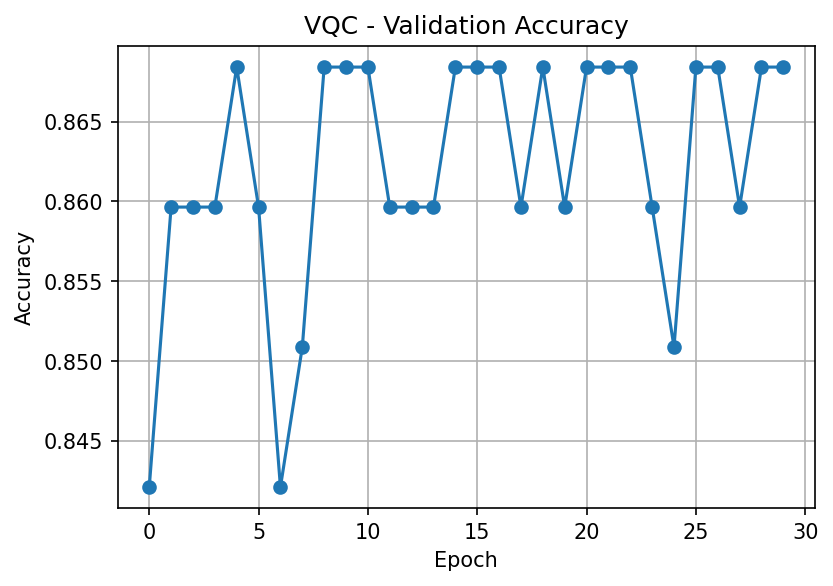

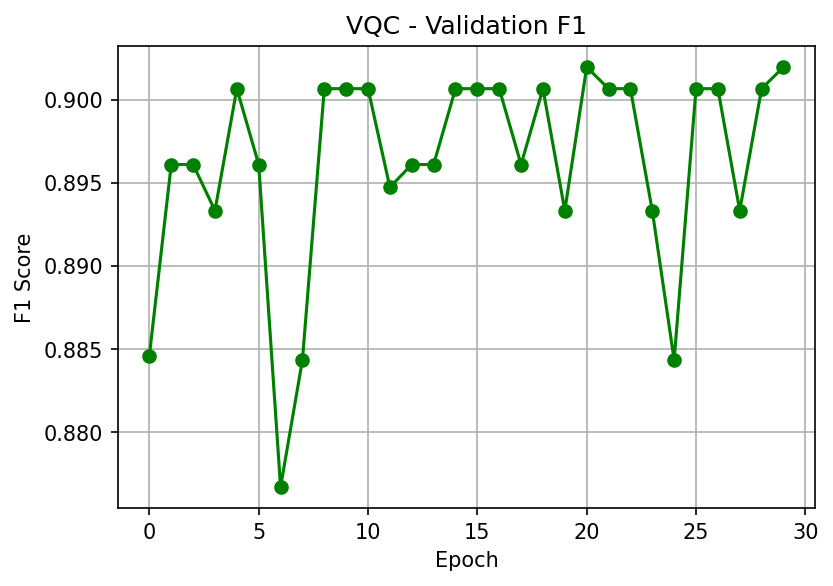

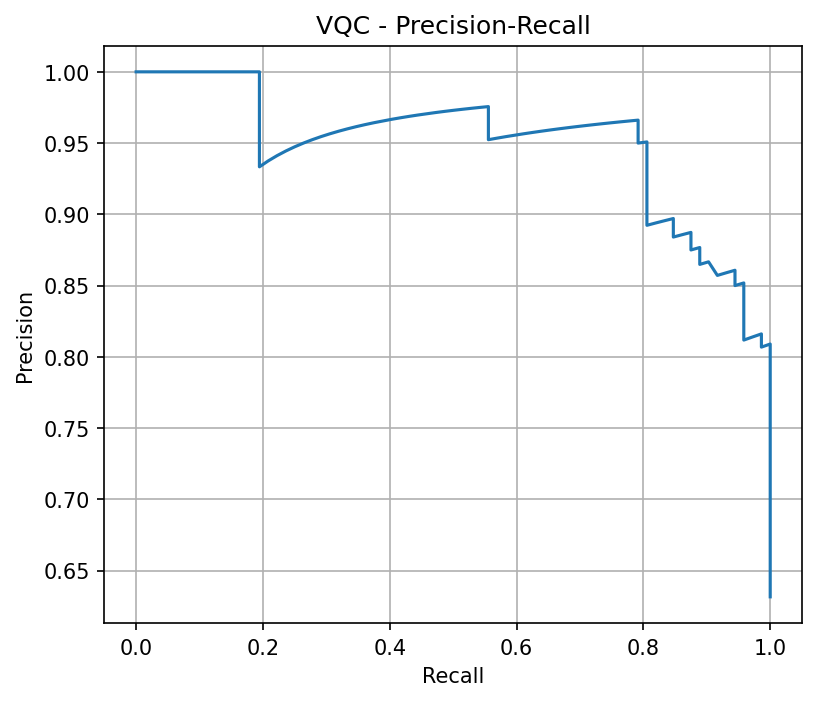

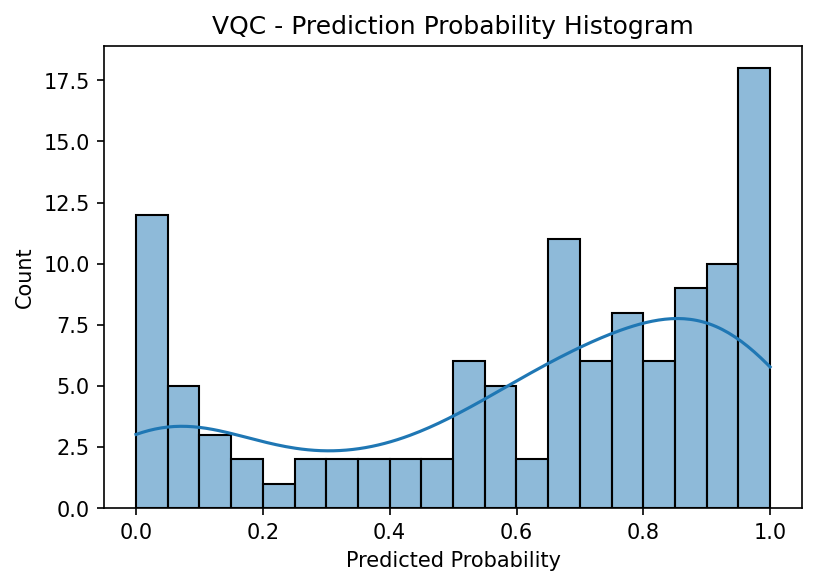

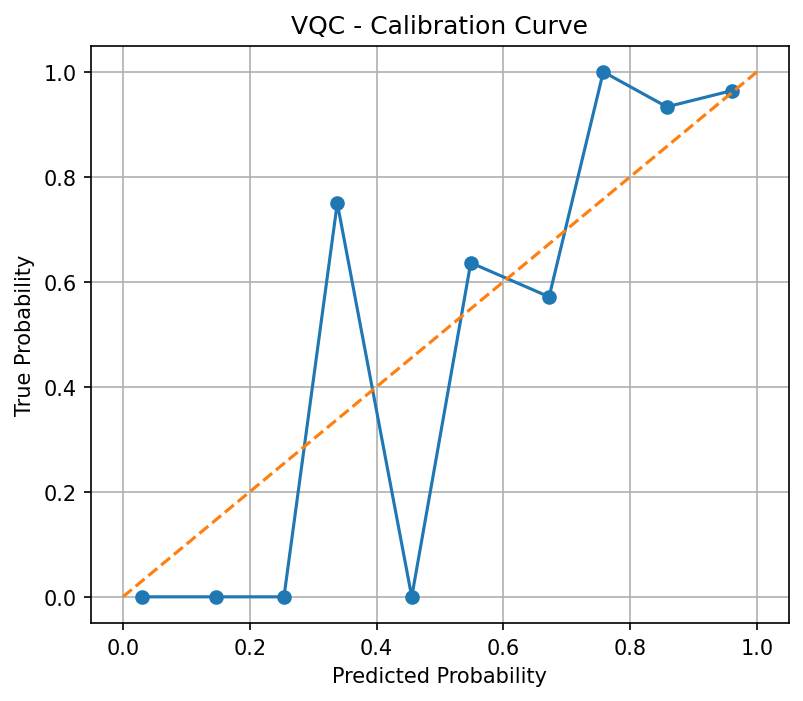

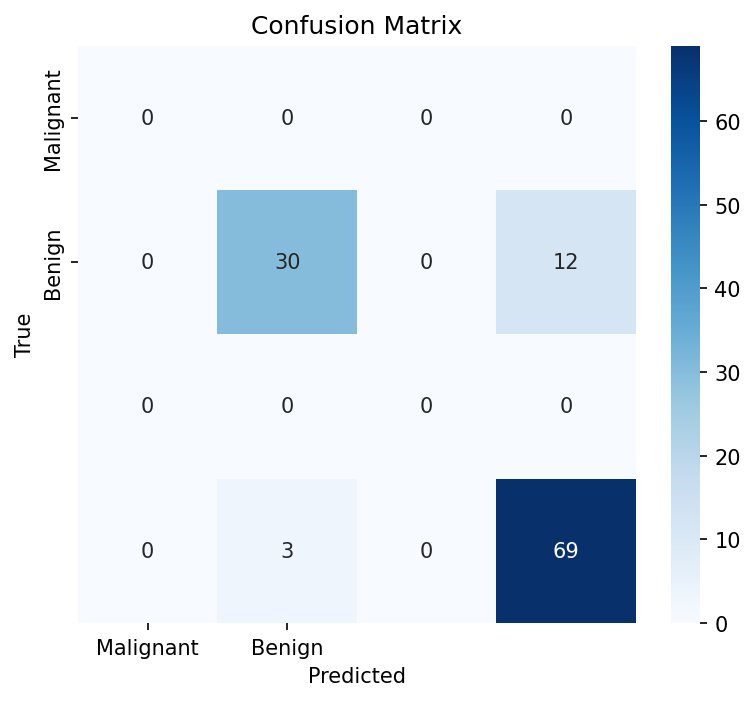

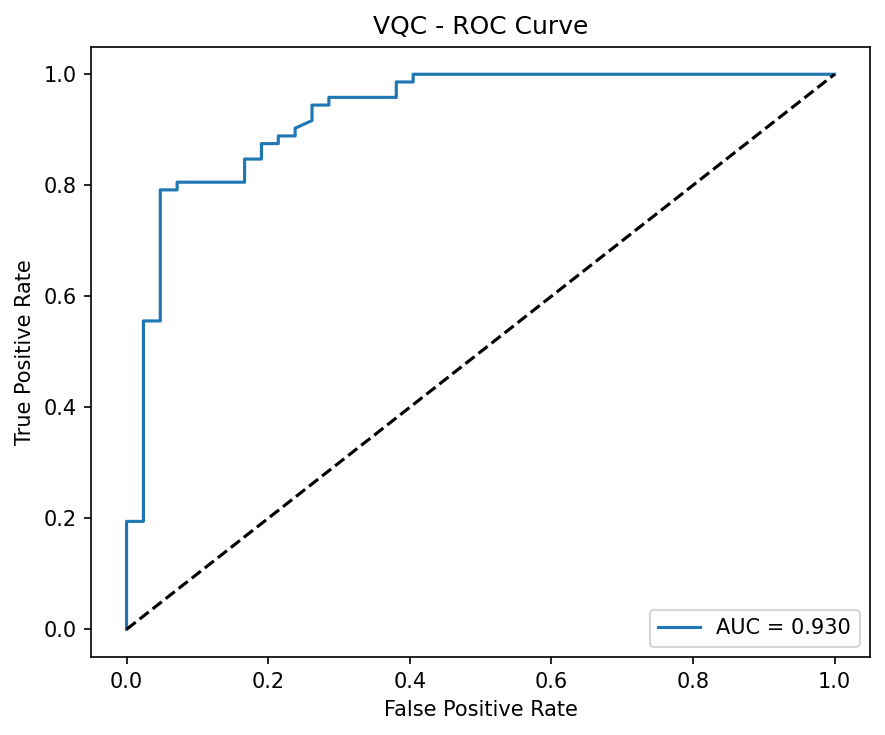

In [17]:
import matplotlib.pyplot as plt

# High-resolution figures
plt.rcParams["figure.dpi"] = 150

# Always show plots inline for Jupyter/VSCode
try:
    get_ipython()
    %matplotlib inline
except:
    pass

# Interactive mode ON for Python scripts
plt.ion()

# train_vqc.py
"""
Variational Quantum Classifier (VQC)
- Mini-batching (simulated by operating on small minibatches)
- Uses first n_qubits features as angle-encoding (NO PCA for training)
- Tracks train/val loss, accuracy, F1; saves many plots
- Requires: pennylane, numpy, scikit-learn, matplotlib, seaborn
"""

import os
import time
import random
import numpy as onp
import pennylane as qml
from pennylane import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer

import matplotlib.pyplot as plt

# ---------------- Config ----------------
RANDOM_SEED = 42
n_qubits = 4            # lower -> faster
batch_size = 32         # mini-batch on feature-subset
n_epochs = 30
stepsize = 0.1
fig_dir = "figures_vqc"
os.makedirs(fig_dir, exist_ok=True)

# ---------------- Seeds ----------------
onp.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


# ---------------- Data ----------------
data = load_breast_cancer()
X = data.data.copy()
y = data.target.copy()

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

# For quantum encoding use first n_qubits features
X_train_q = X_train[:, :n_qubits]
X_test_q = X_test[:, :n_qubits]

# Map labels for MSE loss on expectation [-1,+1]
y_train_map = 2 * y_train - 1
y_test_map = 2 * y_test - 1

# ---------------- Device & Circuit ----------------
dev = qml.device("default.qubit", wires=n_qubits)

def feature_map(x):
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)

@qml.qnode(dev, interface="autograd")
def circuit(x, weights):
    feature_map(x)
    for i in range(n_qubits):
        qml.RY(weights[i], wires=i)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i+1])
    return qml.expval(qml.PauliZ(0))

# ---------------- Optimizer ----------------
weights = np.random.randn(n_qubits, requires_grad=True)
opt = qml.GradientDescentOptimizer(stepsize=stepsize)

# ---------------- Helpers ----------------
def batch_iterator(X_arr, y_arr, batch_size, shuffle=True):
    n = X_arr.shape[0]
    idxs = onp.arange(n)
    if shuffle:
        onp.random.shuffle(idxs)
    for i in range(0, n, batch_size):
        batch_idx = idxs[i:i+batch_size]
        yield X_arr[batch_idx], y_arr[batch_idx]

# ---------------- Training tracking ----------------
train_losses = []
val_losses = []
train_accs = []
train_f1s = []
val_accs = []
val_f1s = []

start_time = time.time()
for epoch in range(1, n_epochs+1):
    epoch_start = time.time()
    # mini-batch updates
    for Xb, yb in batch_iterator(X_train_q, y_train_map, batch_size):
        Xb_p = np.array(Xb)
        yb_p = np.array(yb)

        def cost(w):
            preds = [circuit(x, w) for x in Xb_p]
            preds = np.array(preds)
            return ((preds - yb_p) ** 2).mean()

        weights = opt.step(cost, weights)

    # end of epoch: compute full train and val losses/metrics
    # train loss
    preds_train = np.array([circuit(x, weights) for x in np.array(X_train_q)])
    loss_train = ((preds_train - np.array(y_train_map)) ** 2).mean()
    train_losses.append(float(onp.array(loss_train)))

    # validation loss
    preds_val = np.array([circuit(x, weights) for x in np.array(X_test_q)])
    loss_val = ((preds_val - np.array(y_test_map)) ** 2).mean()
    val_losses.append(float(onp.array(loss_val)))

    # metrics (map expectations to class labels)
    train_preds_labels = (preds_train > 0).astype(int)
    val_preds_labels = (preds_val > 0).astype(int)

    train_acc = accuracy_score(y_train, train_preds_labels)
    train_f1 = f1_score(y_train, train_preds_labels)
    val_acc = accuracy_score(y_test, val_preds_labels)
    val_f1 = f1_score(y_test, val_preds_labels)

    train_accs.append(train_acc)
    train_f1s.append(train_f1)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)

    epoch_time = time.time() - epoch_start
    print(f"[VQC] Epoch {epoch}/{n_epochs} loss_train={train_losses[-1]:.4f} loss_val={val_losses[-1]:.4f} val_acc={val_acc:.4f} time={epoch_time:.2f}s")

total_time = time.time() - start_time
print(f"[VQC] Training finished in {total_time:.1f}s")

# ---------------- Final evaluation on test set ----------------
preds_test_exp = np.array([circuit(x, weights) for x in np.array(X_test_q)])
preds_test_labels = (preds_test_exp > 0).astype(int)
probs_test = ((onp.array(preds_test_exp) + 1.0) / 2.0).tolist()  # map to [0,1] for ROC/AUC

acc = accuracy_score(y_test, preds_test_labels)
f1 = f1_score(y_test, preds_test_labels)
try:
    roc = roc_auc_score(y_test, probs_test)
except Exception:
    roc = None
cm = confusion_matrix(y_test, preds_test_labels)

print("\n[VQC] Test metrics:")
print(f"  Accuracy: {acc:.4f}")
print(f"  F1 score: {f1:.4f}")
print(f"  ROC-AUC: {roc if roc is not None else 'NA'}")
print(f"  Confusion matrix:\n{cm}")


# LOSS CURVE
plt.figure(figsize=(6,4))
plt.plot(range(1, n_epochs+1), train_losses, label='Train MSE')
plt.plot(range(1, n_epochs+1), val_losses, label='Val MSE')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("VQC - Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "vqc_loss_curve.png"), dpi=200)
plt.show()

# ACCURACY & F1
plot_accuracy_curve(val_accs, title="VQC - Validation Accuracy",
                    fname=os.path.join(fig_dir, "vqc_val_acc.png"))
plt.show()

plot_f1_curve(val_f1s, title="VQC - Validation F1",
              fname=os.path.join(fig_dir, "vqc_val_f1.png"))
plt.show()

# PRECISION-RECALL
plot_precision_recall(y_test, probs_test, title="VQC - Precision-Recall",
                      fname=os.path.join(fig_dir, "vqc_pr.png"))
plt.show()

# PROBABILITY HISTOGRAM
plot_probability_hist(probs_test, title="VQC - Prediction Probability Histogram",
                      fname=os.path.join(fig_dir, "vqc_prob_hist.png"))
plt.show()

# CALIBRATION CURVE
plot_calibration_curve(y_test, probs_test, title="VQC - Calibration Curve",
                       fname=os.path.join(fig_dir, "vqc_calibration.png"))
plt.show()

# CONFUSION MATRIX
plot_confusion_matrix_simple(cm, labels=["Malignant","Benign"],
                          fname=os.path.join(fig_dir,"vqc_confusion_norm.png"))
plt.show()

# ROC CURVE
if roc is not None:
    fpr, tpr, _ = roc_curve(y_test, probs_test)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc:.3f}")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("VQC - ROC Curve")
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir,"vqc_roc.png"), dpi=200)
    plt.show()



CONFUSION MATRIX (raw counts):
[[30 12]
 [ 3 69]]
cm.shape = (2, 2)
unique y_true: [0 1]
unique y_pred: [0 1]
len y_true, len y_pred: 114 114


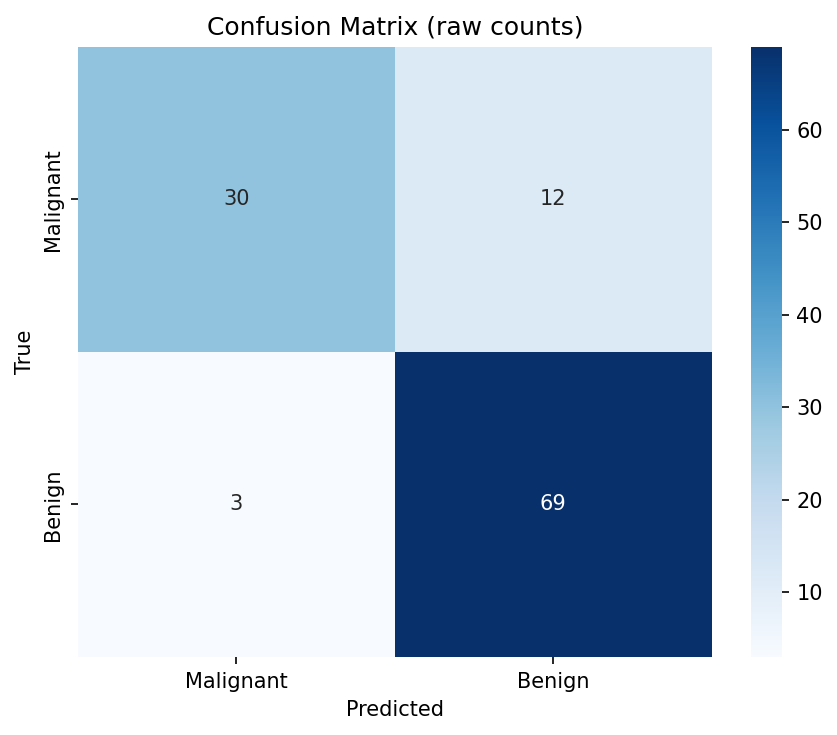

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ---- Replace these with your actual arrays (they must be the same ones you used above) ----
# y_true = y_test
# y_pred = preds_test_labels
y_true = y_test        # ensure this is the same variable used for final eval
y_pred = preds_test_labels  # ensure this is the same predicted labels array

# ---- Force integer dtype and force exactly two labels (0 and 1) ----
y_true = np.array(y_true).astype(int)
y_pred = np.array(y_pred).astype(int)

# compute confusion matrix forcing labels -> guarantees a 2x2 result
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

print("CONFUSION MATRIX (raw counts):")
print(cm)
print("cm.shape =", cm.shape)
print("unique y_true:", np.unique(y_true))
print("unique y_pred:", np.unique(y_pred))
print("len y_true, len y_pred:", len(y_true), len(y_pred))

# ---- Extra safety: if someone accidentally created a flat 4-element array, reshape to 2x2 ----
if cm.ndim == 1 and cm.size == 4:
    cm = cm.reshape(2,2)
    print("Reshaped flat array to 2x2:", cm.shape)

# ---- Plot simple (raw counts) confusion matrix 2x2 ----
labels = ["Malignant", "Benign"]
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix ")
plt.tight_layout()
plt.show()


In [18]:
vqc_acc = acc
vqc_f1 = f1
vqc_auc = roc


[Hybrid] Epoch 1/40 loss=0.6871 val_acc=0.6667 time=6.11s
[Hybrid] Epoch 2/40 loss=0.6432 val_acc=0.7018 time=6.31s
[Hybrid] Epoch 3/40 loss=0.6086 val_acc=0.7456 time=6.31s
[Hybrid] Epoch 4/40 loss=0.5720 val_acc=0.8070 time=6.56s
[Hybrid] Epoch 5/40 loss=0.5372 val_acc=0.8421 time=6.68s
[Hybrid] Epoch 6/40 loss=0.5048 val_acc=0.8684 time=6.71s
[Hybrid] Epoch 7/40 loss=0.4736 val_acc=0.9123 time=6.87s
[Hybrid] Epoch 8/40 loss=0.4434 val_acc=0.9211 time=7.15s
[Hybrid] Epoch 9/40 loss=0.4114 val_acc=0.9561 time=6.92s
[Hybrid] Epoch 10/40 loss=0.3787 val_acc=0.9649 time=6.79s
[Hybrid] Epoch 11/40 loss=0.3456 val_acc=0.9649 time=6.79s
[Hybrid] Epoch 12/40 loss=0.3137 val_acc=0.9649 time=6.51s
[Hybrid] Epoch 13/40 loss=0.2847 val_acc=0.9649 time=6.85s
[Hybrid] Epoch 14/40 loss=0.2571 val_acc=0.9649 time=6.82s
[Hybrid] Epoch 15/40 loss=0.2329 val_acc=0.9649 time=6.88s
[Hybrid] Epoch 16/40 loss=0.2116 val_acc=0.9825 time=6.87s
[Hybrid] Epoch 17/40 loss=0.1923 val_acc=0.9825 time=6.89s
[Hybri

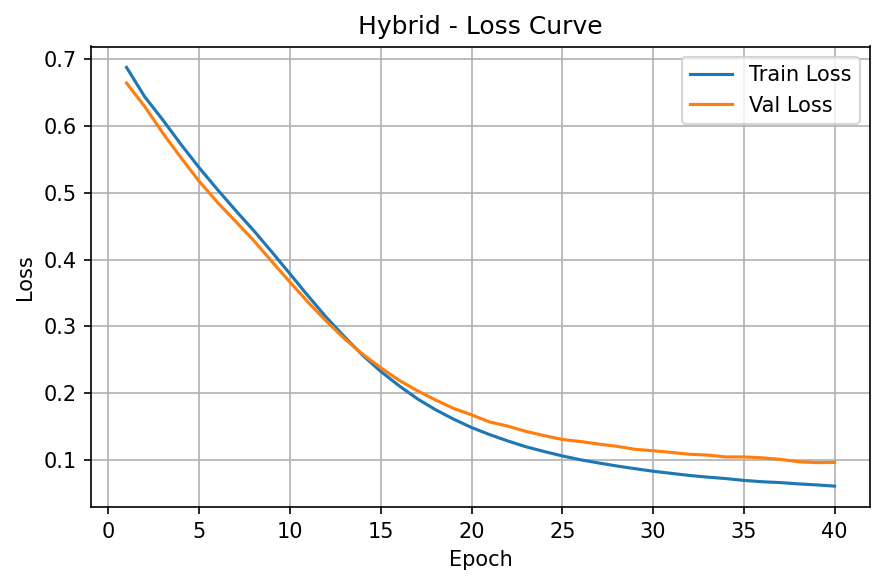

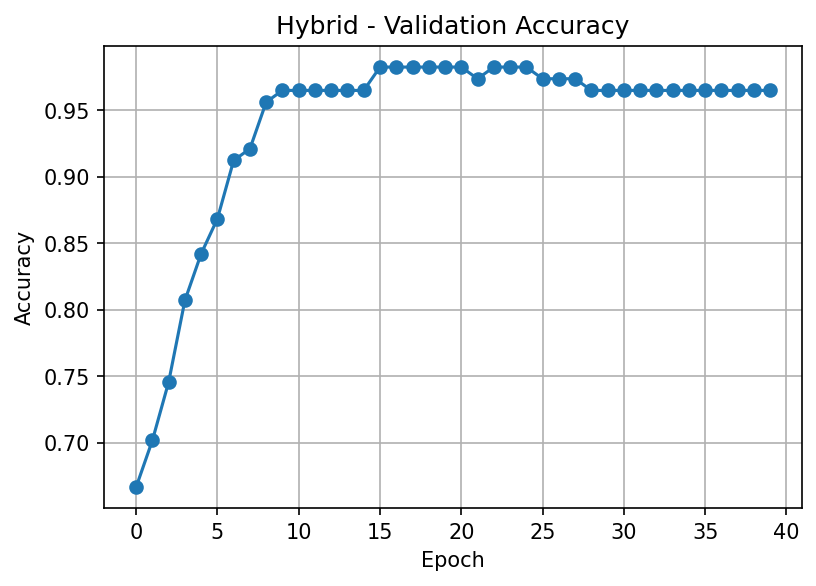

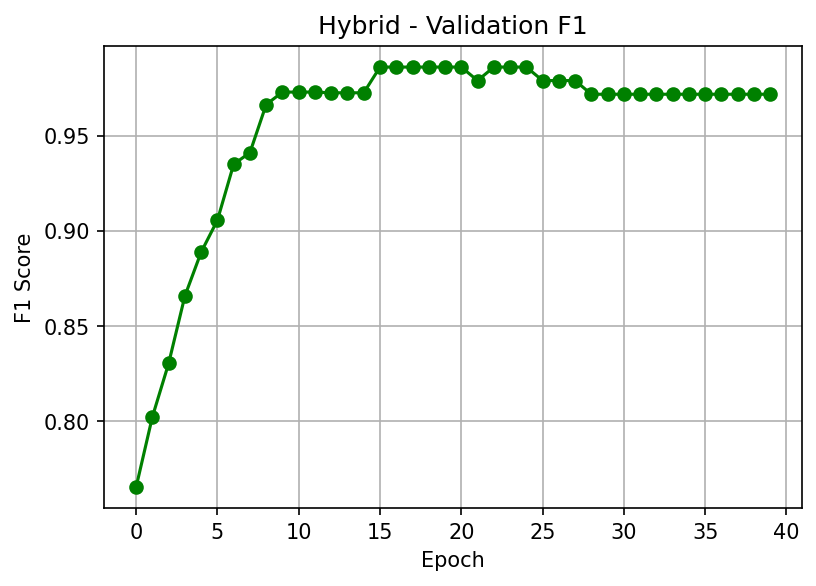

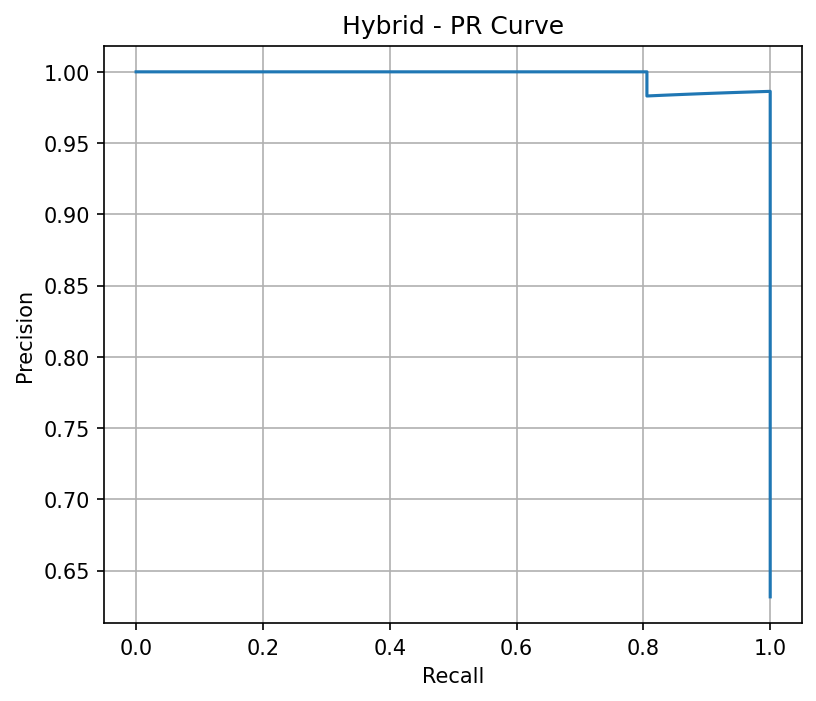

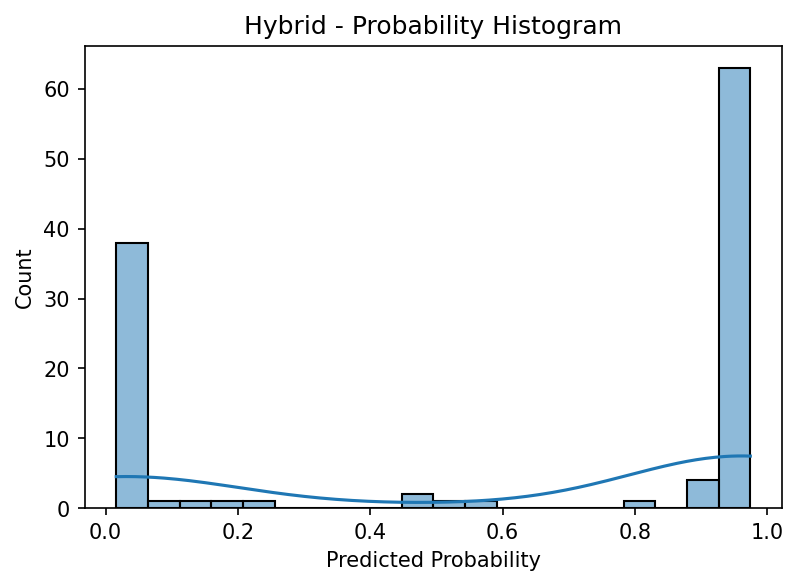

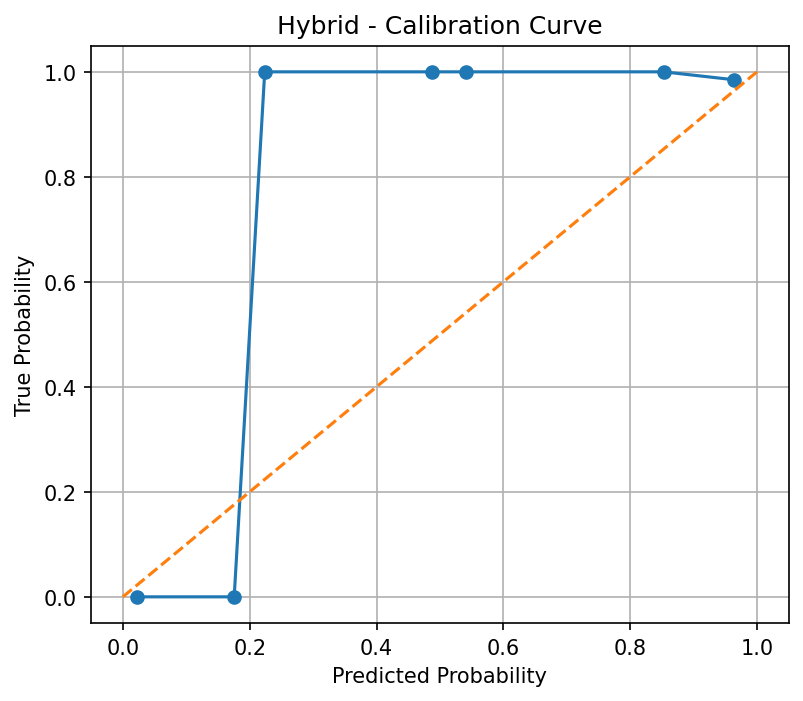

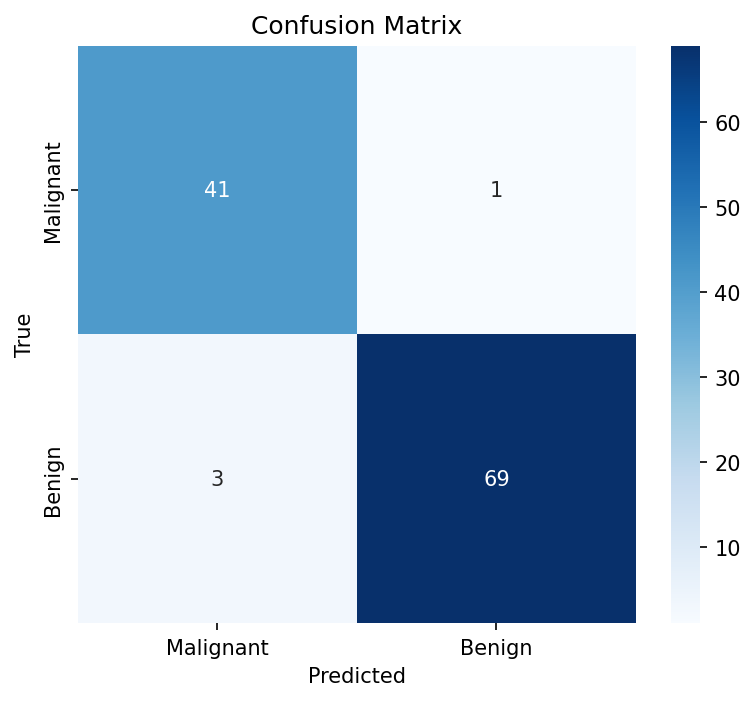

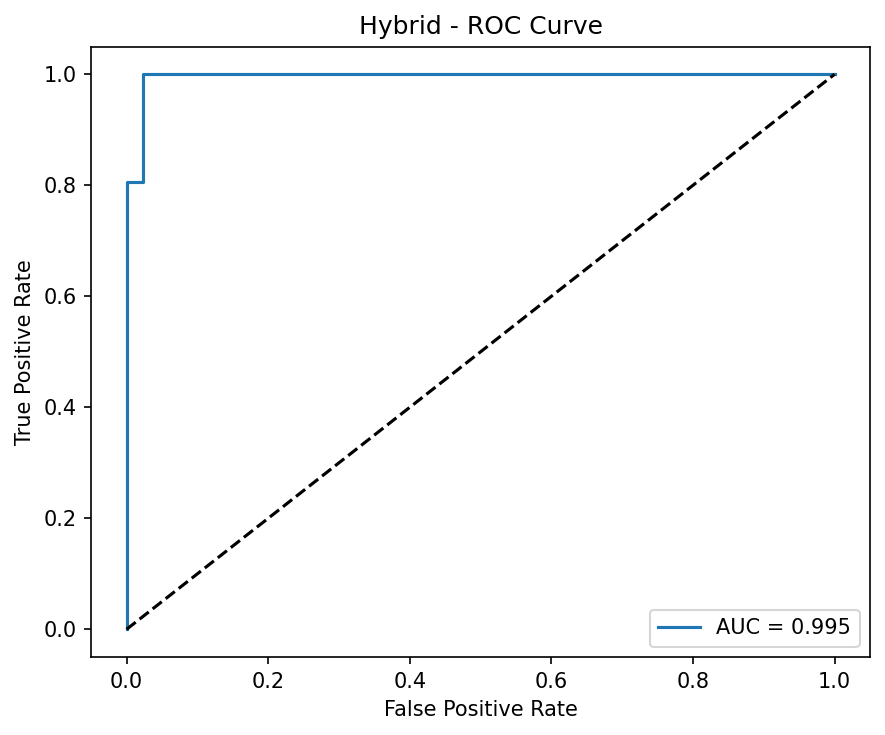

In [21]:
# train_hybrid.py
"""
Hybrid model: classical encoder -> quantum circuit -> classical classifier
- Uses full 30 features for encoder (NO PCA in training)
- End-to-end training via PyTorch + PennyLane (torch interface)
- Tracks loss, accuracy, F1 per epoch; saves plots and metrics
"""

import os
import time
import random
import numpy as onp
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
from pennylane import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

import matplotlib.pyplot as plt

# ---------------- Config ----------------
RANDOM_SEED = 42
n_qubits = 4
n_q_layers = 2
epochs = 40
batch_size = 16
lr = 1e-3
fig_dir = "figures_hybrid"
os.makedirs(fig_dir, exist_ok=True)

# ---------------- Seeds ----------------
onp.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


# ---------------- Data ----------------
X_train, X_test, y_train, y_test = load_and_preprocess(test_size=0.2)
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_test_t = torch.tensor(y_test, dtype=torch.long)

# ---------------- PennyLane device & qnode ----------------
dev = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(dev, interface='torch')
def qnode(inputs, weights):
    # inputs: torch tensor length n_qubits
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)
    for l in range(weights.shape[0]):
        for i in range(n_qubits):
            qml.RY(weights[l][i], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i+1])
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# ---------------- Hybrid PyTorch model ----------------
class HybridNet(nn.Module):
    def __init__(self, input_dim=30, n_qubits=4, n_layers=2, n_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, n_qubits)
        init = 0.01 * torch.randn(n_layers, n_qubits)
        self.q_weights = nn.Parameter(init)
        self.fc2 = nn.Linear(n_qubits, n_classes)

    def forward(self, x):
        x_reduced = torch.tanh(self.fc1(x))  # in [-1,1]
        batch_size = x_reduced.shape[0]
        q_out = []
        for i in range(batch_size):
            q_res = qnode(x_reduced[i], self.q_weights)
            q_out.append(torch.stack(q_res).float())
        q_out = torch.stack(q_out)
        logits = self.fc2(q_out)
        return logits

model = HybridNet(input_dim=30, n_qubits=n_qubits, n_layers=n_q_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# ---------------- Training tracking ----------------
train_losses = []
train_accs = []
train_f1s = []
val_accs = []
val_f1s = []
val_losses = []

n_samples = X_train_t.shape[0]
start_time = time.time()

for epoch in range(1, epochs+1):
    epoch_start = time.time()
    model.train()
    perm = torch.randperm(n_samples)
    running_loss = 0.0

    for i in range(0, n_samples, batch_size):
        idx = perm[i:i+batch_size]
        xb = X_train_t[idx]
        yb = y_train_t[idx]

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)

    epoch_loss = running_loss / n_samples
    train_losses.append(epoch_loss)

    # evaluation
    model.eval()
    with torch.no_grad():
        logits_train = model(X_train_t)
        preds_train = torch.argmax(logits_train, dim=1).numpy()
        train_acc = accuracy_score(y_train, preds_train)
        train_f1 = f1_score(y_train, preds_train)

        logits_val = model(X_test_t)
        probs_val = torch.softmax(logits_val, dim=1)[:,1].numpy()
        preds_val = torch.argmax(logits_val, dim=1).numpy()
        val_acc = accuracy_score(y_test, preds_val)
        val_f1 = f1_score(y_test, preds_val)
        val_loss = criterion(logits_val, y_test_t).item()

    train_accs.append(train_acc)
    train_f1s.append(train_f1)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)
    val_losses.append(val_loss)

    epoch_time = time.time() - epoch_start
    print(f"[Hybrid] Epoch {epoch}/{epochs} loss={epoch_loss:.4f} val_acc={val_acc:.4f} time={epoch_time:.2f}s")

total_time = time.time() - start_time
print(f"[Hybrid] Training finished in {total_time:.1f}s")

# ---------------- Final evaluation ----------------
model.eval()
with torch.no_grad():
    logits_test = model(X_test_t)
    probs_test = torch.softmax(logits_test, dim=1)[:,1].numpy()
    preds_test = torch.argmax(logits_test, dim=1).numpy()

acc = accuracy_score(y_test, preds_test)
f1 = f1_score(y_test, preds_test)
try:
    roc = roc_auc_score(y_test, probs_test)
except Exception:
    roc = None
cm = confusion_matrix(y_test, preds_test)

print("\n[Hybrid] Test metrics:")
print(f"  Accuracy: {acc:.4f}")
print(f"  F1 score: {f1:.4f}")
print(f"  ROC-AUC: {roc if roc is not None else 'NA'}")
print(f"  Confusion matrix:\n{cm}")

# ---------------- Plots ----------------
# LOSS CURVE
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
plt.title("Hybrid - Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "hybrid_loss_curve.png"), dpi=200)
plt.show()

# ACCURACY & F1
plot_accuracy_curve(val_accs, title="Hybrid - Validation Accuracy",
                    fname=os.path.join(fig_dir,"hybrid_val_acc.png"))
plt.show()

plot_f1_curve(val_f1s, title="Hybrid - Validation F1",
              fname=os.path.join(fig_dir,"hybrid_val_f1.png"))
plt.show()

# PRECISION-RECALL
plot_precision_recall(y_test, probs_test, title="Hybrid - PR Curve",
                      fname=os.path.join(fig_dir,"hybrid_pr.png"))
plt.show()

# PROBABILITY HISTOGRAM
plot_probability_hist(probs_test, title="Hybrid - Probability Histogram",
                      fname=os.path.join(fig_dir,"hybrid_prob_hist.png"))
plt.show()

# CALIBRATION CURVE
plot_calibration_curve(y_test, probs_test, title="Hybrid - Calibration Curve",
                       fname=os.path.join(fig_dir,"hybrid_calibration.png"))
plt.show()

# NORMALIZED CONFUSION MATRIX
plot_confusion_matrix_simple(cm, labels=["Malignant","Benign"],
                          fname=os.path.join(fig_dir,"hybrid_confusion_norm.png"))
plt.show()

# ROC CURVE
if roc is not None:
    fpr, tpr, _ = roc_curve(y_test, probs_test)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc:.3f}")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Hybrid - ROC Curve")
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir,"hybrid_roc.png"), dpi=200)
    plt.show()



In [22]:
hybrid_acc = acc
hybrid_f1 = f1
hybrid_auc = roc


In [23]:
results = {
    "classical":  {"acc": classical_acc, "f1": classical_f1, "auc": classical_auc},
    "vqc":        {"acc": vqc_acc,       "f1": vqc_f1,       "auc": vqc_auc},
    "hybrid":     {"acc": hybrid_acc,    "f1": hybrid_f1,    "auc": hybrid_auc}
}


#### BAR CHART for Accuracy, F1, AUC

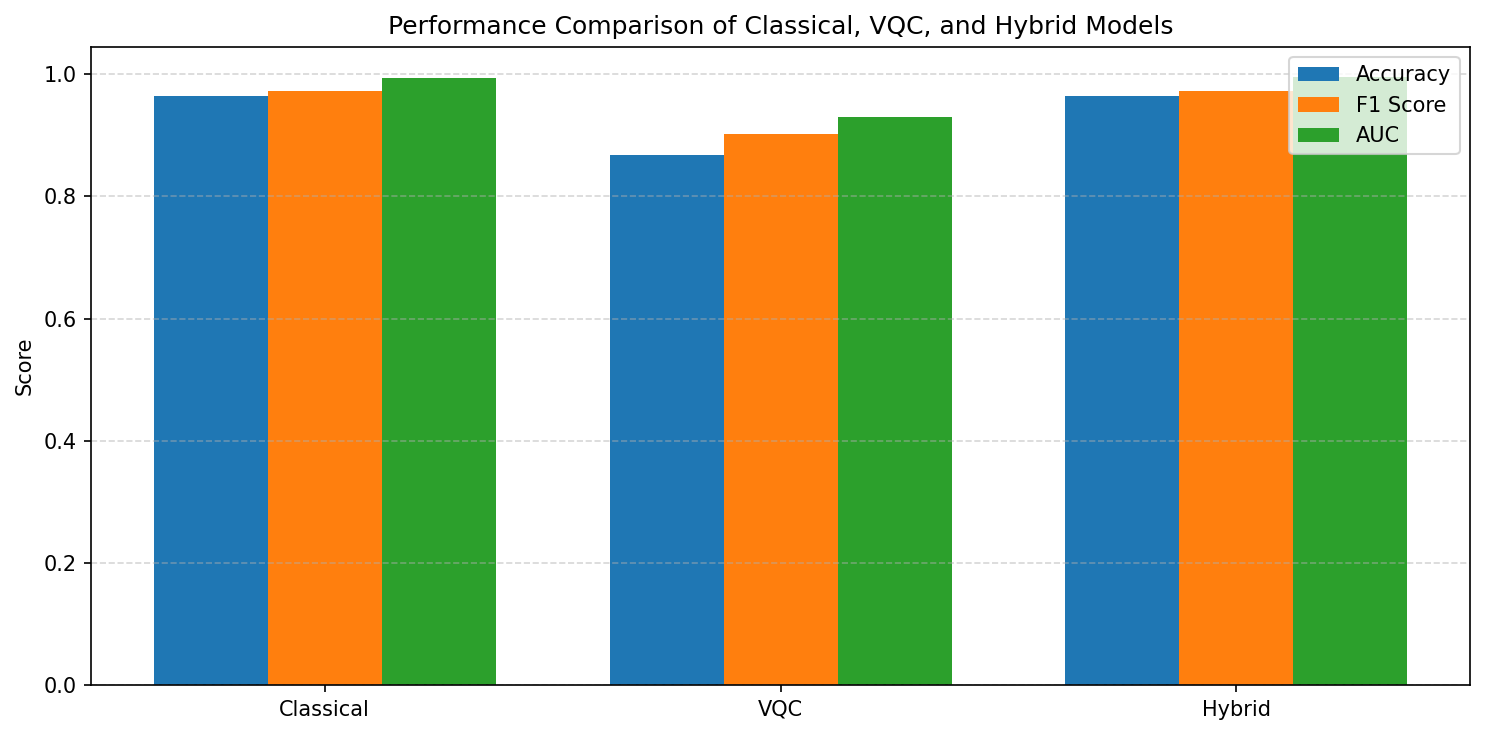

In [24]:
import matplotlib.pyplot as plt
import numpy as np

models = ["Classical", "VQC", "Hybrid"]
accuracy = [results["classical"]["acc"], results["vqc"]["acc"], results["hybrid"]["acc"]]
f1 =       [results["classical"]["f1"],  results["vqc"]["f1"],  results["hybrid"]["f1"]]
auc =      [results["classical"]["auc"], results["vqc"]["auc"], results["hybrid"]["auc"]]

x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(10,5))
plt.bar(x - width, accuracy, width, label='Accuracy')
plt.bar(x,         f1,       width, label='F1 Score')
plt.bar(x + width, auc,      width, label='AUC')

plt.xticks(x, models)
plt.ylabel("Score")
plt.title("Performance Comparison of Classical, VQC, and Hybrid Models")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


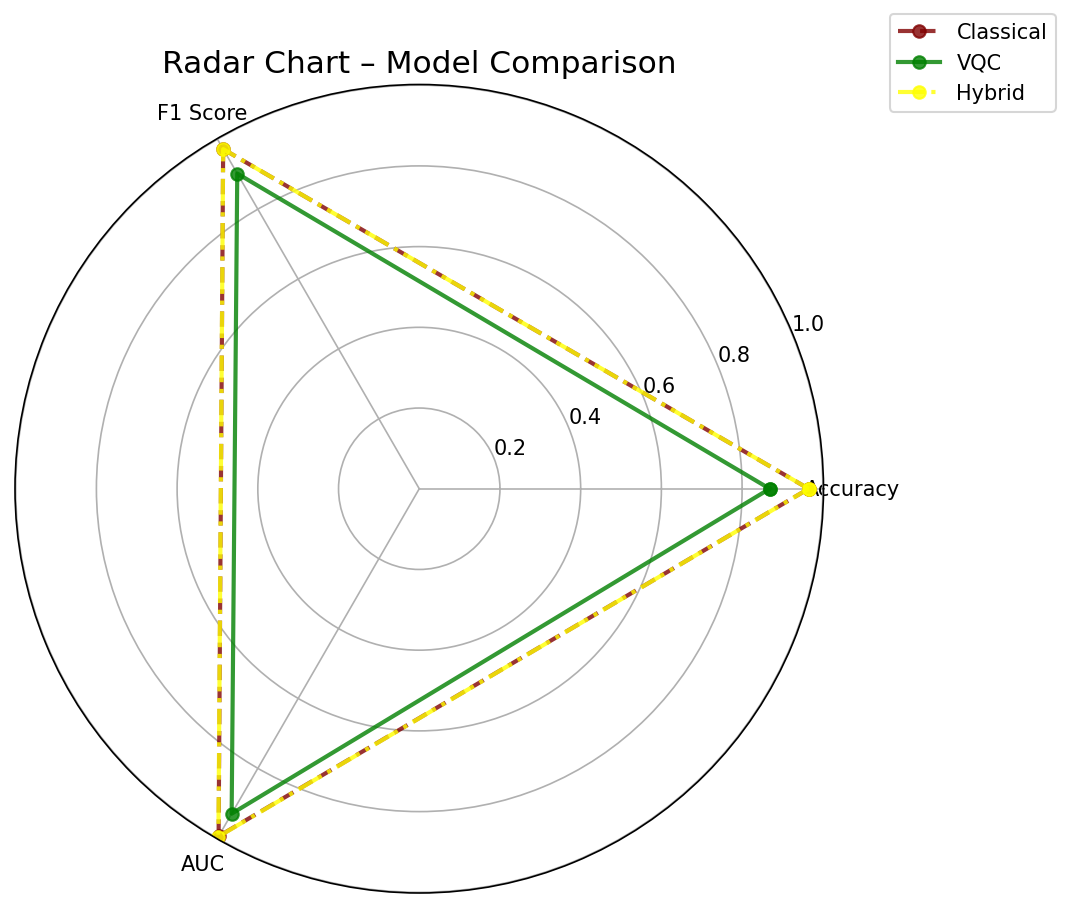

In [33]:
##RADAR / SPIDER PLOT Comparing All Models


from math import pi
import matplotlib.pyplot as plt

metrics = ["Accuracy", "F1 Score", "AUC"]

classical_vals = [results["classical"]["acc"], results["classical"]["f1"], results["classical"]["auc"]]
vqc_vals       = [results["vqc"]["acc"],       results["vqc"]["f1"],       results["vqc"]["auc"]]
hybrid_vals    = [results["hybrid"]["acc"],    results["hybrid"]["f1"],    results["hybrid"]["auc"]]

values = [classical_vals, vqc_vals, hybrid_vals]
labels = ["Classical", "VQC", "Hybrid"]
colors = ["blue","red","green"]

angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
angles += angles[:1]

plt.figure(figsize=(7,7))
line_styles = ["--", "-", "-."]
colors = ["maroon", "green", "yellow"]


for i, model_values in enumerate(values):
    vals = model_values + model_values[:1]
    plt.polar(angles, vals,
              marker="o",
              label=labels[i],
              linewidth=2,
              linestyle=line_styles[i],
              color=colors[i],
              alpha=0.8)


plt.xticks(angles[:-1], metrics)
plt.title("Radar Chart – Model Comparison", size=15)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.show()


In [26]:
##ABLE of All Metrics (for Thesis + Code Included)

import pandas as pd

table = pd.DataFrame({
    "Model": ["Classical", "VQC", "Hybrid"],
    "Accuracy": [results["classical"]["acc"], results["vqc"]["acc"], results["hybrid"]["acc"]],
    "F1 Score": [results["classical"]["f1"], results["vqc"]["f1"], results["hybrid"]["f1"]],
    "ROC-AUC": [results["classical"]["auc"], results["vqc"]["auc"], results["hybrid"]["auc"]],
})

print(table)

table.to_csv("model_comparison_table.csv", index=False)


       Model  Accuracy  F1 Score   ROC-AUC
0  Classical  0.964912  0.971831  0.994378
1        VQC  0.868421  0.901961  0.929729
2     Hybrid  0.964912  0.971831  0.995370


In [27]:
import pandas as pd

table = pd.DataFrame({
    "Model": ["Classical Neural Network", "Variational Quantum Classifier (VQC)", "Hybrid Quantum-Classical Model"],
    "Accuracy (%)": [
        round(results["classical"]["acc"] * 100, 2),
        round(results["vqc"]["acc"] * 100, 2),
        round(results["hybrid"]["acc"] * 100, 2),
    ],
    "F1 Score": [
        round(results["classical"]["f1"], 4),
        round(results["vqc"]["f1"], 4),
        round(results["hybrid"]["f1"], 4),
    ],
    "ROC-AUC": [
        round(results["classical"]["auc"], 4),
        round(results["vqc"]["auc"], 4),
        round(results["hybrid"]["auc"], 4),
    ]
})

# Pretty print
print("\n📌 MODEL PERFORMANCE TABLE\n")
print(table.to_string(index=False))

# Save to CSV
table.to_csv("model_comparison_table.csv", index=False)



📌 MODEL PERFORMANCE TABLE

                               Model  Accuracy (%)  F1 Score  ROC-AUC
            Classical Neural Network         96.49    0.9718   0.9944
Variational Quantum Classifier (VQC)         86.84    0.9020   0.9297
      Hybrid Quantum-Classical Model         96.49    0.9718   0.9954
